In [1]:
import numpy as np
from PIL import Image, ImageDraw
from random import randint
from matplotlib import pyplot as plt
import cv2

In [2]:
class Figure():
    def __init__(self):
        R1 = randint(0,255)
        G1 = randint(0,255)
        B1 = randint(0,255)
        R2 = randint(0,255)
        G2 = randint(0,255)
        B2 = randint(0,255)
        im = Image.new('RGB', (640, 480), (R1,G1,B1))

        draw = ImageDraw.Draw(im)
        H = 480
        W = 640
        h = randint(150,250)
        w = randint(150,250)
        alpha = randint(0,89)*2*np.pi/360
        x1 = -w/2*np.cos(alpha)-h/2*np.sin(alpha)
        y1 = -w/2*np.sin(alpha)+h/2*np.cos(alpha)

        x2 = w/2*np.cos(alpha)-h/2*np.sin(alpha)
        y2 = w/2*np.sin(alpha)+h/2*np.cos(alpha)

        x3 = w/2*np.cos(alpha)+h/2*np.sin(alpha)
        y3 = w/2*np.sin(alpha)-h/2*np.cos(alpha)

        x4 = -w/2*np.cos(alpha)+h/2*np.sin(alpha)
        y4 = -w/2*np.sin(alpha)-h/2*np.cos(alpha)

        x1 = int(x1)
        x2 = int(x2)
        x3 = int(x3)
        x4 = int(x4)
        y1 = int(y1)
        y2 = int(y2)
        y3 = int(y3)
        y4 = int(y4)
        deltax = randint(max((x1,x2,x3,x4)),(W-max((x1,x2,x3,x4))))
        deltay = randint(max((y1,y2,y3,y4)),(H-max((y1,y2,y3,y4))))

        self.x1 = x1+deltax
        self.x2 = x2+deltax
        self.x3 = x3+deltax
        self.x4 = x4+deltax
        self.y1 = y1+deltay
        self.y2 = y2+deltay
        self.y3 = y3+deltay
        self.y4 = y4+deltay
        draw.polygon((self.x1,self.y1,self.x2,self.y2,self.x3,self.y3,self.x4,self.y4), fill=(R2,G2,B2))
        self.X_op = min((self.x1,self.x2,self.x3,self.x4))
        self.Y_op = max((self.y1,self.y2,self.y3,self.y4))
        self.H_op = max((self.y1,self.y2,self.y3,self.y4)) - min((self.y1,self.y2,self.y3,self.y4))
        self.W_op = max((self.x1,self.x2,self.x3,self.x4)) - min((self.x1,self.x2,self.x3,self.x4))
      #  im.save('air_samples/sample1.png','PNG')
        self.image = np.array(im)
    def make_figure(self):
    
        return self.image,self.x1,self.y1,self.x2,self.y2,self.x3,self.y3,self.x4,self.y4
        #return self.image,self.X_op,self.Y_op,self.X_op +self.W_op,self.Y_op+ self.H_op

In [3]:
image = Figure()
image,x1,y1,x2,y2,x3,y3,x4,y4 = image.make_figure()

In [4]:
image.shape

(480, 640, 3)

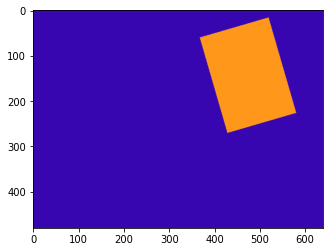

In [5]:
plt.imshow(image)
plt.show()

In [6]:
image_gr = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


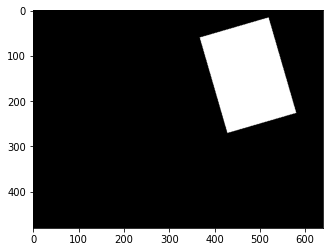

In [7]:
plt.imshow(image_gr,cmap='gray')
plt.show()

In [8]:
image_gr = cv2.blur(image_gr, (10,10)) 

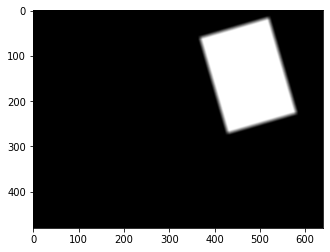

In [9]:
plt.imshow(image_gr,cmap='gray')
plt.show()

In [10]:
image_edged = cv2.Canny(image_gr, 5, 40)

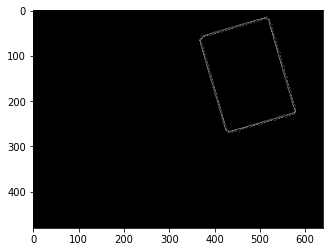

In [11]:
plt.imshow(image_edged,cmap='gray')
plt.show()

In [12]:
def houghLines(edged,rho_res,theta_res,thresholdVotes,filterMultiple,thresholdPixels=0):
    
    rows, columns = edged.shape
    theta = np.linspace(-90, 0, int(np.ceil(90/theta_res)) + 1)
    theta = np.concatenate((theta, -theta[len(theta)-2::-1]))
    
    #defining empty Matrix in Hough space, where x is for theta and y is x*cos(theta)+y*sin(theta)
    diagonal = np.sqrt((rows - 1)**2 + (columns - 1)**2)
    q = int(np.ceil(diagonal/rho_res))
    nrho = 2*q + 1
    rho = np.linspace(-q*rho_res, q*rho_res, nrho)
    houghMatrix = np.zeros((len(rho), len(theta)))
    
    #Here we populate houghMatrix
    for rowId in range(rows):                               #for each x in edged
        for colId in range(columns):                        #for each y in edged
          if edged[rowId, colId]>thresholdPixels:           #edged has values 0 or 255 in our case
            #for each theta we calculate rhoVal, then locate it in Hough space plane
            for thId in range(len(theta)):
              rhoVal = colId*np.cos(theta[thId]*np.pi/180.0)+rowId*np.sin(theta[thId]*np.pi/180)
              rhoIdx = np.nonzero(np.abs(rho-rhoVal) == np.min(np.abs(rho-rhoVal)))[0]
              houghMatrix[rhoIdx[0], thId] += 1  
            

   #cluster and filter multiple dots in Houghs plane
    if filterMultiple>0:
        clusterDiameter=filterMultiple
        values=np.transpose(np.array(np.nonzero(houghMatrix>thresholdVotes)))
        filterArray=[]
        filterArray.append(0)
        totalArray=[]
        for i in range (0, len(values)):
            if i in filterArray[1::]:
                continue
            tempArray=[i]
            for j in range (i+1, len(values)):
                if j in filterArray[1::]:
                    continue
                for k in range (0, len(tempArray)):
                    L = np.sqrt((values[j][0]-values[tempArray[k]][0])**2+(values[j][1]-values[tempArray[k]][1])**2)
                    if L<clusterDiameter:
                        filterArray.append(j)
                        tempArray.append(j)
                        break
            totalArray.append(tempArray)
        
        #leave the highest value in each cluster
        for i in range (0, len(totalArray)):
             for j in range (0, len(totalArray[i])):
                 if j==0:
                     highest=houghMatrix[values[totalArray[i][j]][0],values[totalArray[i][j]][1]]
                     ii=i
                     jj=j
                 else:
                     if houghMatrix[values[totalArray[i][j]][0],values[totalArray[i][j]][1]]>=highest:
                         highest=houghMatrix[values[totalArray[i][j]][0],values[totalArray[i][j]][1]]
                         houghMatrix[values[totalArray[ii][jj]][0],values[totalArray[ii][jj]][1]]=0
                         ii=i
                         jj=j
                     else:
                         houghMatrix[values[totalArray[i][j]][0],values[totalArray[i][j]][1]]=0
                    
    return (np.where(houghMatrix>thresholdVotes)[0]-q)*rho_res, theta[np.where(houghMatrix>thresholdVotes)[1]]*np.pi/180.0


In [17]:
rho,theta = houghLines(image_edged,
                                       rho_res=1,
                                       theta_res=1,
                                       thresholdVotes=70,
                                       filterMultiple=5,
                                       thresholdPixels=0)

In [18]:
print(rho)

[157 335 376 493]


In [19]:
print(theta)

[ 1.29154365 -0.27925268  1.29154365 -0.27925268]


In [20]:
def plotHoughLines(rho,theta,image):
  
    a = -np.cos(theta)/np.sin(theta)
    b = rho/np.sin(theta)
    x = np.linspace(0,64023,600)
    fig2, ax1 = plt.subplots(ncols=1, nrows=1)
    ax1.imshow(image, cmap = 'gray')
    
    for i in range (0, len(rho)):   
        y = a[i]*x+b[i]
        ax1.plot(x, y)
    
    ax1.set_ylim([image.shape[0],0])
    ax1.set_xlim([0,image.shape[1]])
    
    plt.show()

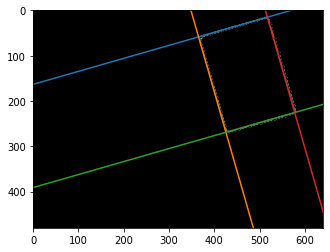

In [21]:
plotHoughLines(rho,theta,image_edged)

In [22]:
difference=np.pi/90
differenceRho=2
accumParallel=[]
for i in range (0, len(theta)):
    for j in range (i+1, len(theta)):
        if theta[j]>(theta[i]-difference) and theta[j]<(theta[i]+difference):
             if rho[j]<(rho[i]-differenceRho) or rho[j]>(rho[i]+differenceRho):
                accumParallel.append([i,j])
a = -np.cos(theta)/np.sin(theta)
b = rho/np.sin(theta)
xy = []
for i in range(2):
    for j in range(2):   
        i1 = accumParallel[0][i]
        i2 = accumParallel[1][j]
        #a[i1]*x+b[i1] = y
        #a[i2]*x+b[i2] = y
        X = [[a[i1],-1],[a[i2],-1]]
        Y = [-b[i1],-b[i2]]
        
        solved = np.linalg.solve(X, Y)
        xy.append([int(solved[0]),int(solved[1])])
print(xy)

[[365, 58], [517, 15], [425, 269], [577, 225]]


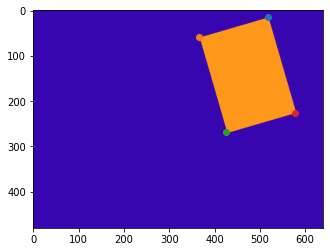

In [23]:
fig2, ax1 = plt.subplots(ncols=1, nrows=1)
ax1.imshow(image)
ax1.scatter(xy[1][0], xy[1][1])
ax1.scatter(xy[0][0], xy[0][1])
ax1.scatter(xy[2][0], xy[2][1])
ax1.scatter(xy[3][0], xy[3][1])
plt.savefig('pic5.png')

In [32]:
L2_1 = np.sqrt((x1-xy[0][0])**2+(y1-xy[0][1])**2)
L2_2 = np.sqrt((x2-xy[2][0])**2+(y2-xy[2][1])**2)
L2_3 = np.sqrt((x3-xy[3][0])**2+(y3-xy[3][1])**2)
L2_4 = np.sqrt((x4-xy[1][0])**2+(y4-xy[1][1])**2)

In [33]:
L2 = np.mean((L2_1,L2_2,L2_3,L2_4))
L2

3.2817506346874548